In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import regex as re
import datetime as dt
import statistics as stats
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
import random as pyr

In [59]:
df_foodcenter = pd.read_csv('food_center_pred/train.csv')
print(df_foodcenter.shape)
df_foodcenter.head()

(456548, 9)


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [60]:
df_foodcenter.checkout_price.map(lambda v: v <= 55).sum()

4

In [61]:
df_foodcenter.duplicated().sum()

0

In [62]:
df_foodcenter_meal = pd.read_csv('food_center_pred/meal_info.csv')
print(df_foodcenter_meal.cuisine.value_counts())
df_foodcenter_meal.head()

Thai           15
Indian         12
Italian        12
Continental    12
Name: cuisine, dtype: int64


,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [63]:
df_foodcenter = pd.merge(
    left=df_foodcenter[df_foodcenter.week <= 140], right=df_foodcenter_meal, how='left', on='meal_id')
print(df_foodcenter.shape)
df_foodcenter.head()

(440172, 11)


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian


#### <b>Update about the dataset:</b>
- Our assumption that food ingredients are purchased on weekly basis may be reasonable, as according to the data source: <br></br> <i>"The replenishment of majority of raw materials is done on weekly basis and since the raw material is perishable, the procurement planning is of utmost importance. Secondly, staffing of the centers is also one area wherein accurate demand forecasts are really helpful. Given the following information, the task is to predict the demand for the next 10 weeks (Weeks: 146-155) for the center-meal combinations in the test set"</i>

#### <b>Pre-Processing</b>
- In the dataset, the range of price does not seem to be measured by U. S. Dollars and no information was provided regarding currency.
- An arbitary transformation is applied to make the price figure looks like USD.

In [64]:
df_foodcenter[['checkout_price', 'base_price']].isna().sum()

checkout_price    0
base_price        0
dtype: int64

count    440172.000000
mean        331.807637
std         153.183564
min           2.970000
25%         228.920000
50%         293.000000
75%         442.320000
max         866.270000
Name: checkout_price, dtype: float64
count    440172.000000
mean        353.994264
std         160.869472
min          55.350000
25%         243.500000
50%         310.430000
75%         458.840000
max         866.270000
Name: base_price, dtype: float64


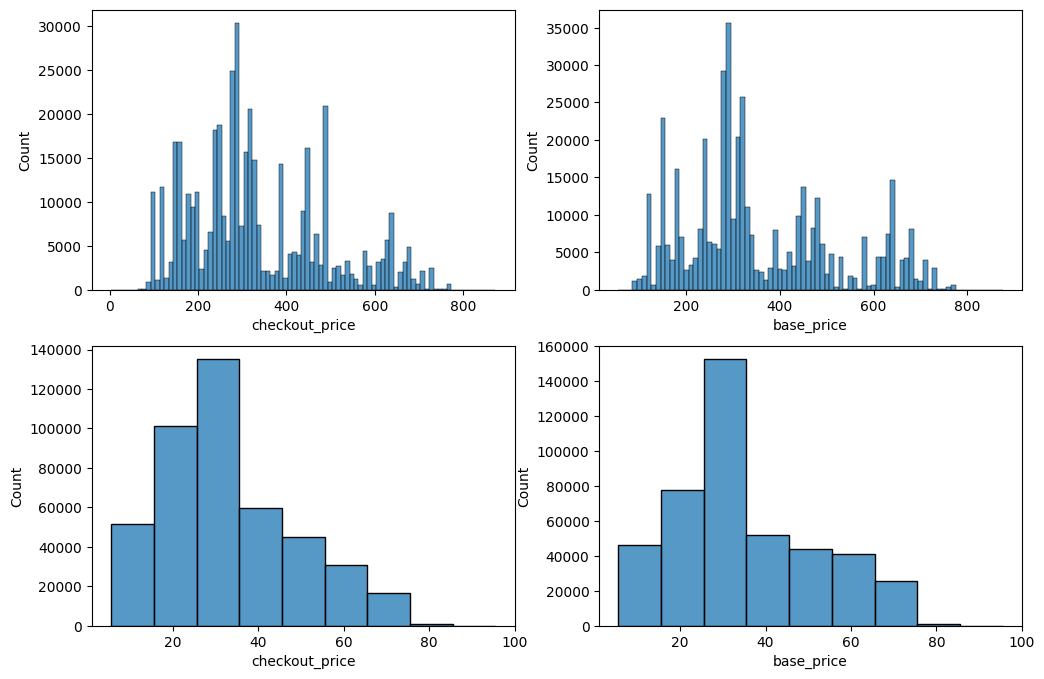

In [65]:
f, a1 = plt.subplots(nrows=2, ncols=2,)
f.set_figheight(8,)
f.set_figwidth(12,)

plt.subplot(2,2,1)
fig = sns.histplot(data = df_foodcenter, x= 'checkout_price', binwidth=10)

plt.subplot(2,2,2)
fig = sns.histplot(data = df_foodcenter, x= 'base_price', binwidth=10)

print(df_foodcenter.checkout_price.describe())
print(df_foodcenter.base_price.describe())


def price_transformer(p) -> float:
    if p is not float:
        p = float(p)
    if p < 55:
        p = 55
    return (p / 10)


df_foodcenter[['checkout_price', 'base_price',]] = df_foodcenter[['checkout_price', 'base_price',]].applymap(price_transformer)
df_foodcenter['diff_price'] = df_foodcenter.checkout_price -  df_foodcenter.base_price


plt.subplot(2,2,3)
fig = sns.histplot(data = df_foodcenter, x= 'checkout_price', binwidth=10)

plt.subplot(2,2,4)
fig = sns.histplot(data = df_foodcenter, x= 'base_price', binwidth=10)

#### <b>Demand analysis</b>
- Order frequency, as measured by the <b><i>num_orders</i></b> column in the dataset, is considered to represent demand.
- Order frequency is assumed to be stationary over time and is thus considered as a random variable rather than stochastic process.
- Snippets below give an estimate of the statistical properties of demand.

<AxesSubplot:title={'center':'weekly order count over time'}, xlabel='week', ylabel='num_orders'>

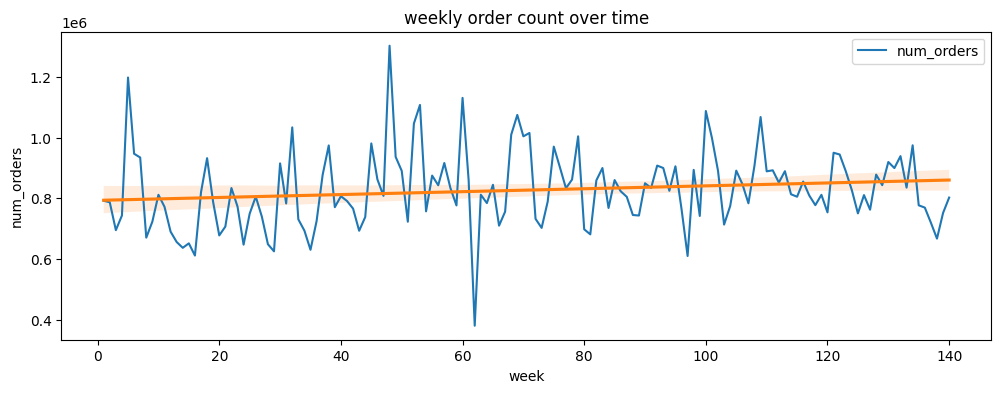

In [66]:
df_foodcenter.groupby('week').agg(
    num_orders=pd.NamedAgg(column='num_orders', aggfunc='sum'),
).plot(kind='line', figsize=(12, 4)).set_title('weekly order count over time')

sns.regplot(
    data=df_foodcenter.groupby('week').agg(num_orders=pd.NamedAgg(column='num_orders', aggfunc='sum'),
).reset_index()[['week', 'num_orders']],
    x='week', y='num_orders', scatter=True, marker='',
)

- In the original dataset there are dozens of food centers. It might be better to focus on only few of them as it reduces complexity of the problem.
- As a result, the top 6 popular centers, as measured by their total number of orders across the time, are selected and the rest are removed from consideration.

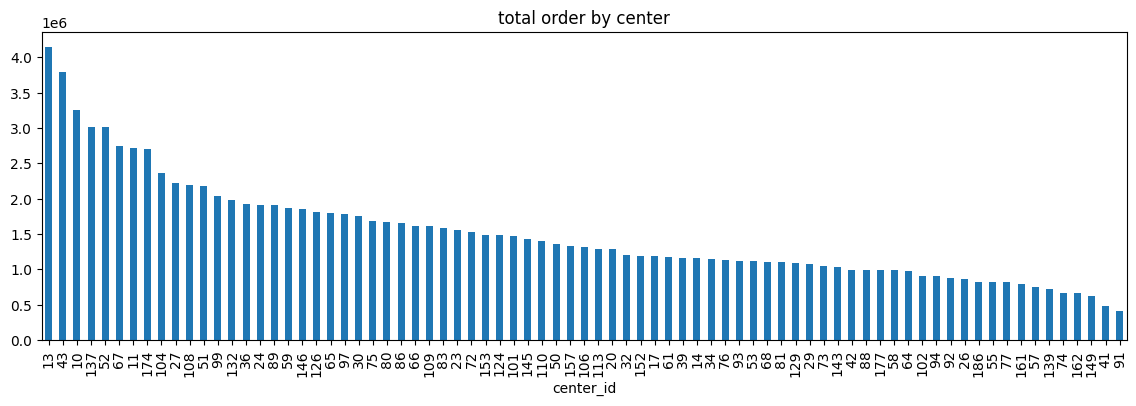

<Figure size 1300x400 with 0 Axes>

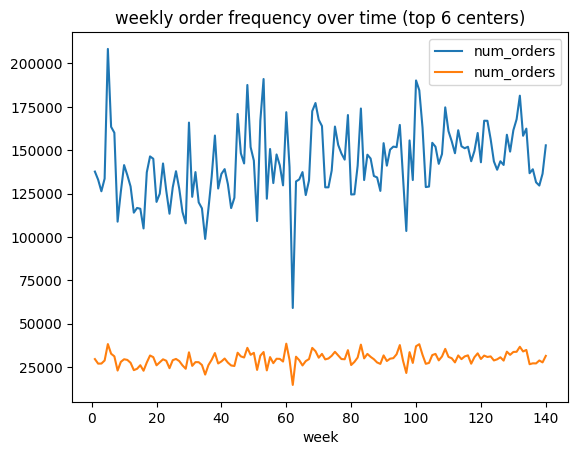

In [67]:
order_by_center = df_foodcenter.groupby('center_id').agg(
    num_orders=pd.NamedAgg(column='num_orders', aggfunc='sum')
)['num_orders'].sort_values(ascending=False)
order_by_center.plot(kind='bar', figsize=(
    14, 4)).set_title("total order by center")


df_foodcenter_popular = df_foodcenter.loc[
    df_foodcenter.index.map(
        lambda i: df_foodcenter.loc[i, 'center_id'] in order_by_center.index[:6])
]


df_temp = df_foodcenter_popular.groupby('week').agg(
    num_orders=pd.NamedAgg(column='num_orders', aggfunc='sum'),
)
fig = plt.figure(figsize = (13, 4))
df_temp.plot(kind='line',).set_title(
    'weekly order frequency over time (top 6 centers)')
# sns.regplot(
#     data=df_temp.reset_index()[['week', 'num_orders']],
#     x='week', y='num_orders', scatter=True, marker='',
# )


df_temp = df_foodcenter_popular[df_foodcenter_popular.center_id == order_by_center.index[0]]
df_temp = df_temp.groupby('week').agg('sum')['num_orders']
df_temp.plot(kind = 'line')
plt.legend()
plt.show()
# lb_test = sm.stats.acorr_ljungbox(df_temp.values, return_df=True)
# print(lb_test)

- In this dataset, there are many distribution centers. It may help if narrow down our focus to only few of them, as it helps reduce the complexity as well as repetitive works in this simulation.
- The top six most popular food centers, as measured by their total number of orders across the time, were selected.

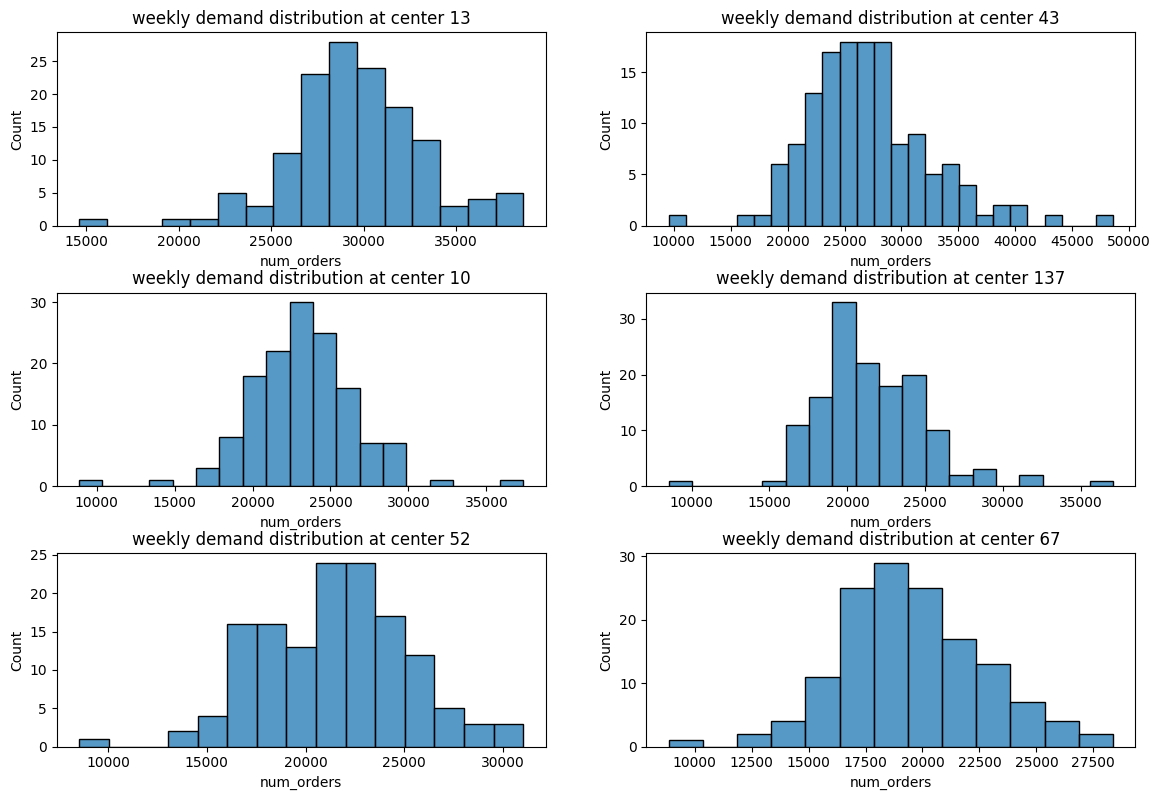

In [68]:
f, a1 = plt.subplots(ncols=2, nrows=3,)
f.tight_layout(pad=0.8)
f.set_figheight(8,)
f.set_figwidth(12,)
counter = 1
for c_id in order_by_center.index[:6]:
    plt.subplot(3, 2, counter)
    plt.title("weekly demand distribution at center " + str(c_id))
    counter += 1
    df_temp = df_foodcenter_popular[df_foodcenter_popular.center_id == c_id]
    df_temp = df_temp.groupby('week').agg(func='sum')['num_orders'].to_frame()
    #df_temp['num_orders'].plot(kind='hist')
    sns.histplot(data = df_temp, x = 'num_orders', binwidth = 1500),
    df_temp['des_num_order'] = df_temp.num_orders.map(
        lambda n: round(float(n), 0))
    #df_temp.to_csv(f"weekly demand %s.csv" % str(c_id))

##### <b>Distribution fitting of weekly demand (based on raw data without outlier removal or any other processing)</b>
The results below were acquired using @rist distribution batch fit:
- weekly demand of center 10: $Logistic(23273.1,1791.8)$
- weekly demand of center 13: $Logistic(29668.1,2009.1)$
- weekly demand of center 43: $LogLogistic(-7252.4,33859,11.756)$
- weekly demand of center 52: $Normal(21528.2,3702.3)$
- weekly demand of center 67: $Logistic(19481.8,1765.0)$
- weekly demand of center 137: $LogLogistic(-10392,31699,17.297)$
<br></br>
- Discrete distribution were also tried yet the results were worse than those of continuous fitting.
- As shown, there are three distribution groups, logistic, loglogistic, and normal. 
- May need to consider if demands at each center are homogenous.

In [69]:
counter = 0
for c_id in order_by_center.index[:6]:
    counter += 1
    df_temp = df_foodcenter_popular[df_foodcenter_popular.center_id == c_id]
    df_temp = df_temp.groupby('week').agg(func='sum')['num_orders']
    test_res = scipy.stats.normaltest(df_temp)
    print("center " + str(c_id) + " normality test", end='\t\t')
    print("stat: " + str(round(test_res[0], 4)), end='\t')
    print("p val: " + str(round(test_res[1], 4)), end='\n')


center 13 normality test		stat: 9.1451	p val: 0.0103
center 43 normality test		stat: 16.8223	p val: 0.0002
center 10 normality test		stat: 14.3812	p val: 0.0008
center 137 normality test		stat: 20.7838	p val: 0.0
center 52 normality test		stat: 1.3137	p val: 0.5185
center 67 normality test		stat: 2.5159	p val: 0.2842


- normality test suggests demand at center 52 and 67 could be from normal

#### <b>Price Analysis</b>
- There are two types of price in the dataset, <b><i>base price</i></b> and <b><i>checkout price</i></b>. 
- Checkout price is the price to be studied as it suggests how much the customer was charged for an order.
- Both checkout price and base price in the dataset have the following patterns:
- - One meal in one week at different centers can have different prices.
- - One meal at one center in different weeks can have different prices.
- - The checkout price and base price at a given center and during a specified week does not change.
- - According to visualization, the price distribution does not vary across centers.
##### Decomposition of checkout price
- Considering an observation of demand (i.e., an order), it may be one of the many meals in the dataset. The price of this observation is thus a random variable. Its randomness contains two aspects:
- - a) The customer's random choice of meals, which decides a base price $P_{base}$.
- - b) The random effect of promotion events and discount policies, which can be modelled by another random variable $P_{promo}$, clearly $P_{promo} <= 0$.
- - The checkout price of an observation is therefore decided by $P_{checkout} = P_{base} + P_{promo}$
- - For simplicity, assume $P_{base}$ and  $P_{promo}$ are independent, we can then focus on the analysis of checkout price alone.
- - Note: The checkout price could also be determined by the product rather than sum of base and promo price, yet based on the following analysis the addition model is more probable.

Text(0.5, 1.0, 'distribution of checkout price by center')

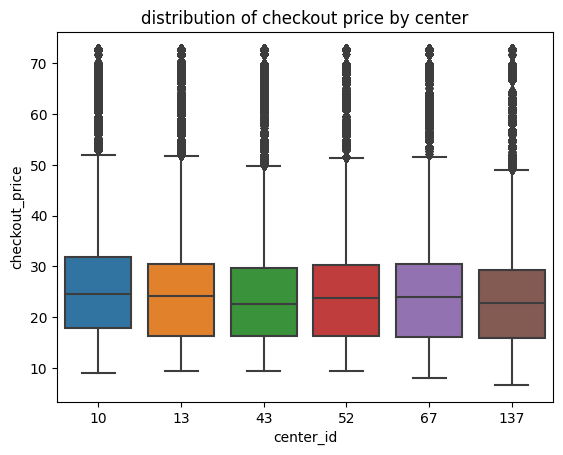

In [70]:
checkout_price_and_freq = zip(df_foodcenter_popular.checkout_price, df_foodcenter_popular.num_orders)

checkout_price_and_freq = [[p] * f for p,f in checkout_price_and_freq]

checkout_price_arr = []
for price_list in checkout_price_and_freq:
    checkout_price_arr.extend(price_list)


center_id_and_freq = zip(df_foodcenter_popular.center_id, df_foodcenter_popular.num_orders)

center_id_and_freq = [[p] * f for p,f in center_id_and_freq]

center_id_arr = []
for price_list in center_id_and_freq:
    center_id_arr.extend(price_list)


df_temp = pd.DataFrame({
    'center_id':center_id_arr,
    'checkout_price' : checkout_price_arr,
})

sns.boxplot(data = df_temp, x = 'center_id', y = 'checkout_price').set_title('distribution of checkout price by center')

- The box plot suggests the distribution of price does not vary across centers.

In [71]:
# an example of the price patterns in the dataset
df_foodcenter_popular.groupby(['meal_id', 'center_id', 'week']).agg('first')[['checkout_price', 'base_price']].head()

checkout_price  base_price
meal_id center_id week                            
1062    10        1             18.139      18.139
                  2             18.336      18.236
                  3             18.436      18.236
                  4             18.236      18.336
                  5             18.339      18.139

,checkout_price,base_price,diff_price
checkout_price,1.000000,0.955568,0.009873
base_price,0.955568,1.000000,-0.285322
diff_price,0.009873,-0.285322,1.000000


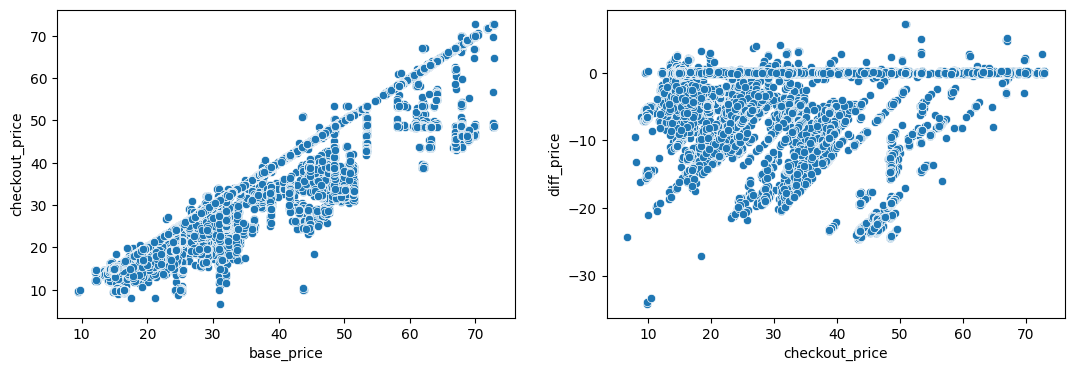

In [72]:
fig, ax = plt.subplots(1,2)
fig.set_figwidth(13)
fig.set_figheight(4)


plt.subplot(1,2,1)
sns.scatterplot(data = df_foodcenter_popular, y='checkout_price', x = 'base_price')

plt.subplot(1,2,2)
sns.scatterplot(data = df_foodcenter_popular, y='diff_price', x = 'checkout_price')

df_foodcenter_popular[['checkout_price', 'base_price', 'diff_price']].corr()

count    40324.000000
mean        -2.142442
std          4.692108
min        -34.150000
25%         -2.034750
50%         -0.100000
75%          0.097000
max          7.278000
Name: diff_price, dtype: float64

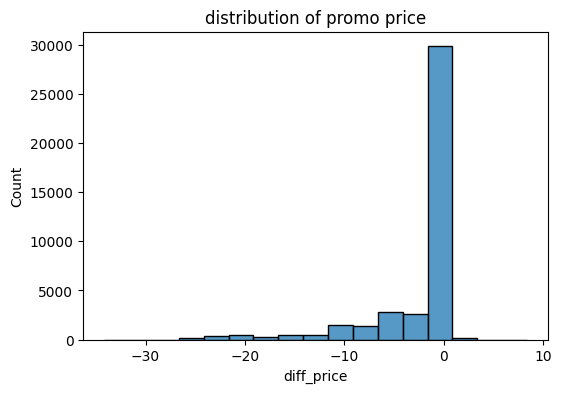

In [73]:
plt.figure(figsize = (6,4))
sns.histplot(data = df_foodcenter_popular, x = 'diff_price', binwidth = 2.5).set_title('distribution of promo price')
df_foodcenter_popular.diff_price.describe()

In [74]:
df_price = df_foodcenter_popular.groupby(['week', 'center_id', 'meal_id']).agg(
    checkout_price=pd.NamedAgg(column='checkout_price', aggfunc='first'),
    num_orders=pd.NamedAgg(column='num_orders', aggfunc='sum'),
).reset_index()
df_price.center_id = df_price.center_id.astype(str)


Text(0.5, 1.0, 'checkout price of meal 2539 over time by center')

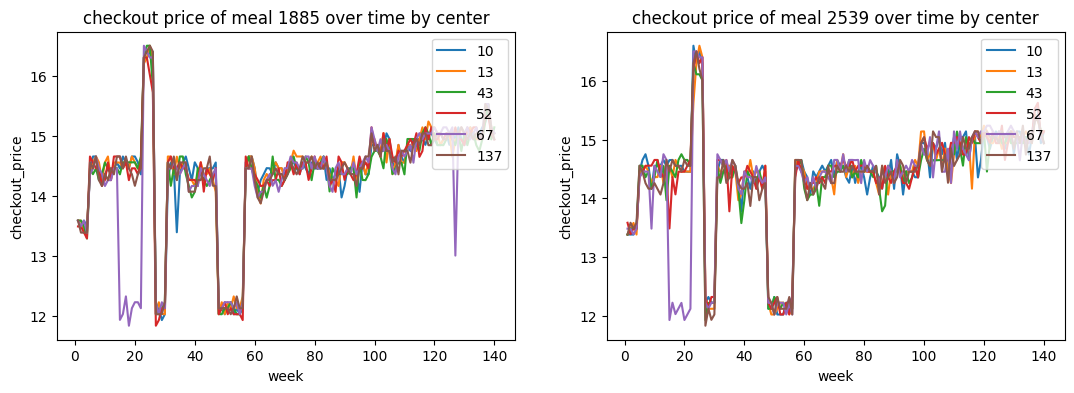

In [75]:
fig,ax = plt.subplots(1,2)
fig.set_figwidth(13)
fig.set_figheight(4)


df_temp = df_price[df_price.meal_id == 1885]
plt.subplot(1,2,1)
sns.lineplot(data=df_temp, x='week', y='checkout_price', hue='center_id')
plt.legend(loc='upper right')
plt.title('checkout price of meal 1885 over time by center')


df_temp = df_price[df_price.meal_id == 2539]
plt.subplot(1,2,2)
sns.lineplot(data=df_temp, x='week', y='checkout_price', hue='center_id')
plt.legend(loc='upper right')
plt.title('checkout price of meal 2539 over time by center')


- The plot suggests that the checkout price of a meal might not be stationary over time. The huge fluctuation of price during certain period may result from unknown random factors.
- We can also filter out checkout price observations that are outside the interval $[14, 16]$ to acquire a set of price observations that are roughly stationary.
- From personal perspective, the abnormal observations are kept, as they enhance the generality of the simulation model.

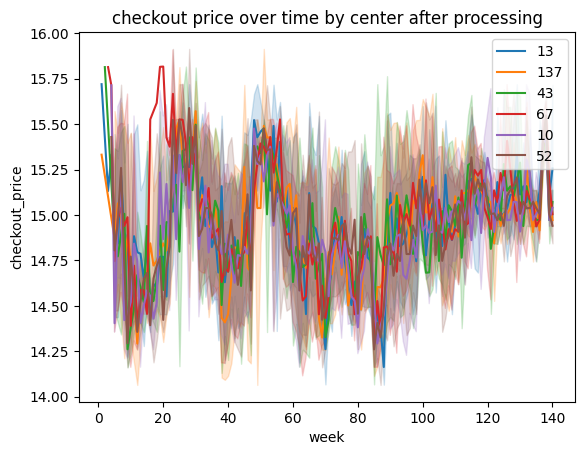

In [76]:
df_price_processed = df_price[(df_price.checkout_price >= 14) & (
    df_price.checkout_price <= 16)]
sns.lineplot(data=df_price_processed, x='week',
             y='checkout_price', hue='center_id')
plt.legend(loc='upper right')
plt.title('checkout price over time by center after processing')
plt.show()

##### Distribution fitting of checkout price
- Owing to efficiency issue, orignal price observations are downsampeld to an array of 5000 elements for distribution fitting in @risk.

In [77]:
checkout_price_and_freq = zip(df_foodcenter_popular.checkout_price, df_foodcenter_popular.num_orders)

checkout_price_and_freq = [[p] * f for p,f in checkout_price_and_freq]

checkout_price_arr = []
for price_list in checkout_price_and_freq:
    checkout_price_arr.extend(price_list)

checkout_price_arr[:5]

[13.586000000000002,
 13.586000000000002,
 13.586000000000002,
 13.586000000000002,
 13.586000000000002]

Text(0.5, 1.0, 'distribution of checkout price (downsampled to 10000)')

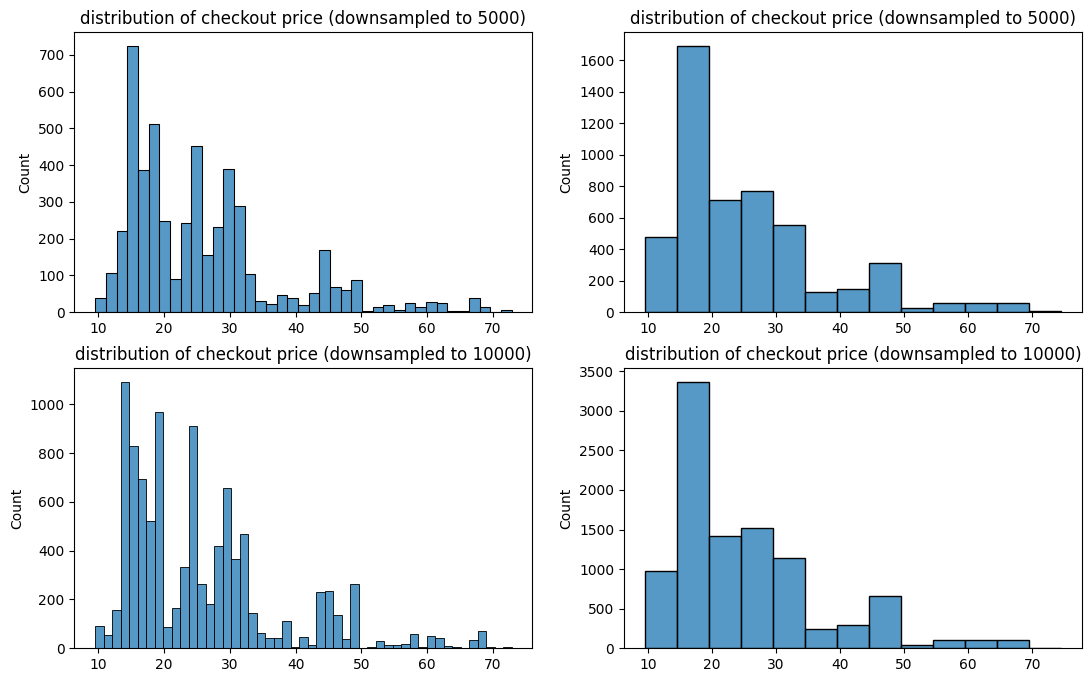

In [78]:
len(checkout_price_arr)
checkout_price_arr = np.random.choice(checkout_price_arr, size = 5000)
checkout_price_arr_alt = np.random.choice(checkout_price_arr, size = 10000)

fig,ax = plt.subplots(2,2)
fig.set_figwidth(13)
fig.set_figheight(8)


plt.subplot(2,2,1)
sns.histplot(data = checkout_price_arr).set_title('distribution of checkout price (downsampled to 5000)')

plt.subplot(2,2,2)
sns.histplot(data = checkout_price_arr, binwidth = 5).set_title('distribution of checkout price (downsampled to 5000)')

plt.subplot(2,2,3)
sns.histplot(data = checkout_price_arr_alt).set_title('distribution of checkout price (downsampled to 10000)')

plt.subplot(2,2,4)
sns.histplot(data = checkout_price_arr_alt, binwidth = 5).set_title('distribution of checkout price (downsampled to 10000)')

In [79]:
#pd.Series(checkout_price_arr).to_frame('checkout_price').to_csv('checkout_price_ds5000.csv', index=False)

<img src="DF_CP_DS5000.png"/>
<br></br>

-  $InvGauss(19.084,44.194,RiskShift(6.7773))$ appears to best fit the sample data. 
-  $Lognorm(18.293,13.114,RiskShift(7.6351))$ is the secondary best.

- The modelling of customer behavior, as represented by $P_{checkout}$ , is thus finished.

##### <b> Summary of modelling logic</b>
- Every week, at each center, there will be certain amount of food delivery orders. It is modelled by a random variable $D_{(center, week)}$. The distribution of $D$ is decided by the center alone and is time-stationary.
- As for an observation of order, it may purchase one (for simplicity) of the many meals offered by the company. After the selection of meal, the customer/company may use/apply discount policies/promotion strategies, which then decide the actual checkout price of the observation. The randomness here is modelled by $P_{checkout} = P_{base} + P_{promo}$.
- As it is assumed that the base price and the promo price be independent. We simulate checkout price solely without probing much into the two component prices.

In [80]:
# price_arr = df_price.checkout_price
# price_downsample_arr = np.random.choice(price_arr, size=10000)
# # pd.DataFrame({'price': price_downsample_arr}).to_csv(
# #     'price_arr_downsample.csv', index=False)
# print("count of observations in price array:\t", price_arr.shape)


# f, a = plt.subplots(nrows=2, ncols=2,)
# f.suptitle('distribution of the original and downsampled')
# f.set_figheight(6)
# f.set_figwidth(12)
# plt.subplot(2,2,1)
# sns.histplot(x=price_arr)
# plt.subplot(2,2,2)
# sns.histplot(x=price_downsample_arr)

# price_downsample_arr = np.random.choice(price_arr, size=5000)
# # pd.DataFrame({'price': price_downsample_arr}).to_csv(
# #     'price_arr_downsample.csv', index=False)
# plt.subplot(223)
# sns.histplot(x=price_downsample_arr)

# price_downsample_arr = np.random.choice(price_arr, size=1000)
# pd.DataFrame({'price': price_downsample_arr}).to_csv(
#     'price_arr_downsample1000.csv', index=False)
# plt.subplot(224)
# sns.histplot(x=price_downsample_arr)

In [81]:
# candidate_dist = [distributions.norm,
#                   distributions.logistic, distributions.expon]
# for d in candidate_dist:
#     parameters = d.fit(price_arr)
#     mu = parameters[0]
#     sigma = parameters[1]
#     x = np.linspace(price_arr.min(), price_arr.max(), 100)
#     pdf = d.pdf(x, mu, sigma)
#     plt.figure(figsize=(6, 4))
#     plt.hist(price_arr, bins=10, density=True, alpha=0.6, label='Data',)
#     plt.plot(x, pdf, 'r-', label='Fitted Distribution')
#     plt.xlabel('Value')
#     plt.ylabel('Density')
#     plt.title(str(d.name) + ' fitted on unprocessed price array')
#     plt.legend()
#     plt.show()


#### <b>Budget Analysis</b>
- Available information from the dataset that helps with budget analysis is revenue, as acquired by multiplying number of orders with corresponding checkout price.
<br></br>
- According to Internet info, the price of an order is roughly comprised of:
- - 40% cost
- - 20% delivery cost (paid to third-party deliverer in the case that a company does not have its own delivery crew)
- - 40% raw profit
<br></br>
- According to dataset info, the company operates as both the food provider and delivery service provider. It is thus assumed that:
- - 60% of an order's checkout price is cost
- - 40% of an order's checkout price is the raw profit.
<br></br>
- Following this logic, calculate the average weekly cost per center $\overline{C}$ and apply a linear transform such as $B = 2.5 * \overline{C}$ to get a budget constraint.

In [82]:
df_foodcenter_popular.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,diff_price
194,1171094,1,13,1885,13.586,12.228,0,1,2132,Beverages,Thai,1.358
195,1068455,1,13,1993,13.486,12.228,0,1,2418,Beverages,Thai,1.258
196,1105491,1,13,2539,13.386,13.386,0,0,474,Beverages,Thai,0.000
197,1486384,1,13,2139,33.762,43.753,0,0,123,Beverages,Indian,-9.991
198,1345938,1,13,2631,25.223,43.747,0,0,162,Beverages,Indian,-18.524


C:\Users\Chaconne\AppData\Local\Temp\ipykernel_7872\1583017438.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_foodcenter_popular['revenue'] = df_foodcenter_popular.index.map(


,center_id,week,center_weekly_orders,center_weekly_revenue
0,10,1,25327,706987.721
1,10,2,21561,603366.034
2,10,3,22411,592697.078
3,10,4,22794,631619.556
4,10,5,35934,819267.505


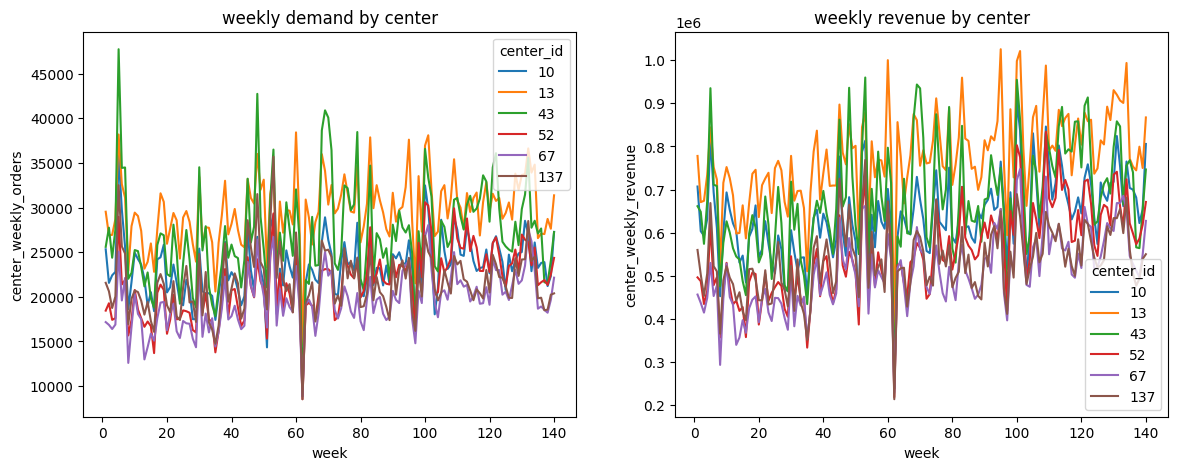

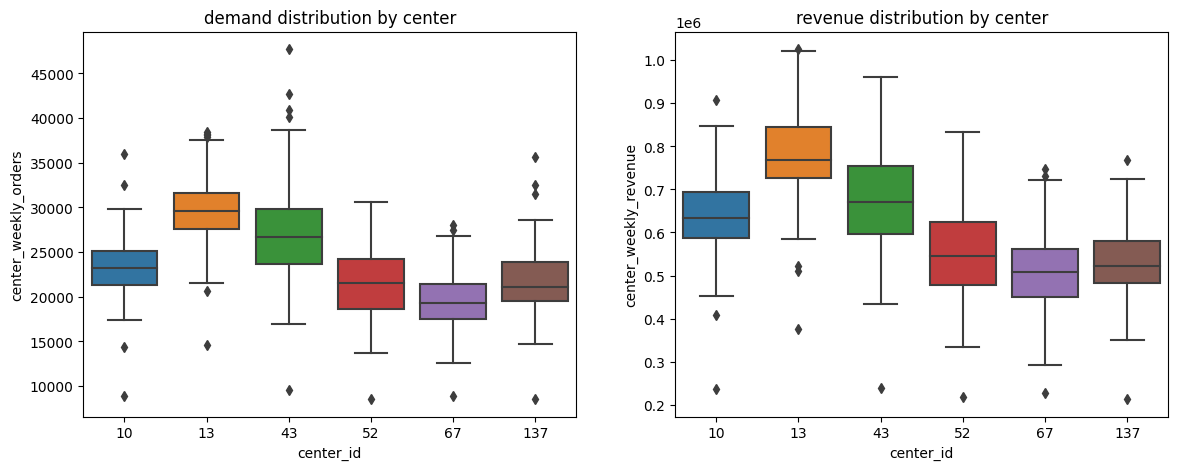

In [83]:
df_foodcenter_popular['revenue'] = df_foodcenter_popular.index.map(
    lambda i: df_foodcenter_popular.loc[i, 'num_orders'] * df_foodcenter_popular.loc[i, 'checkout_price']
)


df_revenue = df_foodcenter_popular.groupby(['center_id', 'week']).agg(
    center_weekly_orders = pd.NamedAgg(column = 'num_orders', aggfunc = 'sum'),
    center_weekly_revenue = pd.NamedAgg(column = 'revenue', aggfunc ='sum' ),
).reset_index()
df_revenue.center_id = df_revenue.center_id.astype(str)

fig, ax = plt.subplots(1, 2, )
fig.set_figwidth(14)
fig.set_figheight(5)
plt.subplot(1, 2, 1)
sns.lineplot(data = df_revenue, x = 'week', hue = 'center_id', y='center_weekly_orders').set_title('weekly demand by center')
plt.subplot(1, 2, 2)
sns.lineplot(data = df_revenue, x = 'week', hue = 'center_id', y='center_weekly_revenue').set_title('weekly revenue by center')


fig, ax = plt.subplots(1, 2, )
fig.set_figwidth(14)
fig.set_figheight(5)
plt.subplot(1, 2, 1)
sns.boxplot(data = df_revenue, x = 'center_id', y='center_weekly_orders').set_title('demand distribution by center')
plt.subplot(1, 2, 2)
sns.boxplot(data = df_revenue, x = 'center_id', y='center_weekly_revenue').set_title('revenue distribution by center')


df_revenue.head()

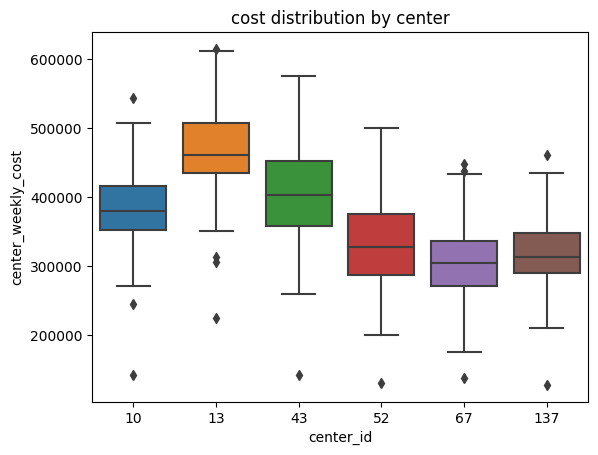

In [84]:
df_revenue['center_weekly_cost'] = df_revenue.center_weekly_revenue.map(lambda r: 0.6 * r)
df_revenue['center_weekly_profit'] = df_revenue.center_weekly_revenue.map(lambda r: 0.4 * r)

fig = sns.boxplot(data = df_revenue, x = 'center_id', y='center_weekly_cost')
fig.set_title('cost distribution by center')
fig.ticklabel_format(style='plain', axis='y')

In [85]:
df_revenue.groupby('center_id').agg('mean')['center_weekly_cost'].mean()

368959.4658778571

- The average weekly operational cost of the six centers are some 368,959.47$
- If applying the formula $B = 2.5 * \overline{C}$ and round it to integer, the cost constraint is some 920,000$.

#### <b>Budget Analysis II</b>
- The previous analysis is ill-formed as the cost calculated was actually a function of demand, which makes the cost a random variable.
- Instead of applying a monetary budget, apply a numerical budget on <b>the number of items that could be bought and distributed to the food centers</b>.
- According to the snippet below, average weekly demand among the six selected centers are around 23787. The constraint of total number of items could be bought weekly can then be set to 50,000 to create a resource allocation problem between two centers.
- - e.g., $\sum S_{i} <= 50000$ where $S_{i}$  is the big S at a center.

In [86]:
df_revenue.groupby('center_id').agg('mean')['center_weekly_orders'].mean()

23787.464285714286

#### <b> Reformulation of the Problem</b>
- Terp Delivery Inc. is a food delivery company that operates in several cities across the states. It provides both food and delivery services to its customers. 
- Currently, Terp Delivery Inc. is seeking expansion and has identified six potential locations, namely <i><b>10, 13, 43, 52, 67, and 137</b></i>. For confidential purpose, the locations are denoted using numbers instead of their true names.
- Apart from the ongoing expansion plan, Terp Delivery Inc. also wants to optimize its inventory management by applying an (s, S) policy that devides how much raw materials its food delivery centers should buy weekly.
- The marketing team of Terp Delivery Inc. has conducted market research and built a simulation model to bettter project the performance if a delivery center is built at the location. The simulation model is comprised of the following components:
- <b>Decision variables</b>:
- - - Selection of locations to expand.
- - - Inventory policy (s, S), one for each selected locations.
- <b>Random inputs</b>:
- - Checkout price: the total amount of an order, it follows $InvGauss(19.084,44.194,RiskShift(6.7773))$
- - Weekly demand: the total of orders processed at a center during one week. Each center's distribution is distinct:
- - - weekly demand of center 10: $Logistic(23273.1,1791.8)$
- - - weekly demand of center 13: $Logistic(29668.1,2009.1)$
- - - weekly demand of center 43: $LogLogistic(-7252.4,33859,11.756)$
- - - weekly demand of center 52: $Normal(21528.2,3702.3)$
- - - weekly demand of center 67: $Logistic(19481.8,1765.0)$
- - - weekly demand of center 137: $LogLogistic(-10392,31699,17.297)$
- <b>Constraints</b>:
- - Owing to cash flow issue, the maximum number of raw materials that Terp Delivery Inc. can buy and distribute to the new centers weekly cannot exceed 50,000.

#### <b>Random number generators</b>
- The snippets below discuss the effect of generating random numbers in Python

##### Random generation of checkout price:
- - $InvGauss(19.084,44.194,RiskShift(6.7773))$
- - $Lognorm(18.293,13.114,RiskShift(7.6351))$
<br></br>
- As both the distributions have no upper bound, use the maximum observation to truncate generated random values.
- The work of random number generator is messy in that the API's have no common standards. Parameters to be fed into the function is thus very ambiguous.

In [87]:
from scipy.stats import invgauss, lognorm

a1 = 19.084 + 6.7773
b1= 44.194

a2 = 18.293 + 7.6351
b2 = 13.114

maximum price 	 72.853


Text(0.5, 1.0, 'Lognormal by Python built-in')

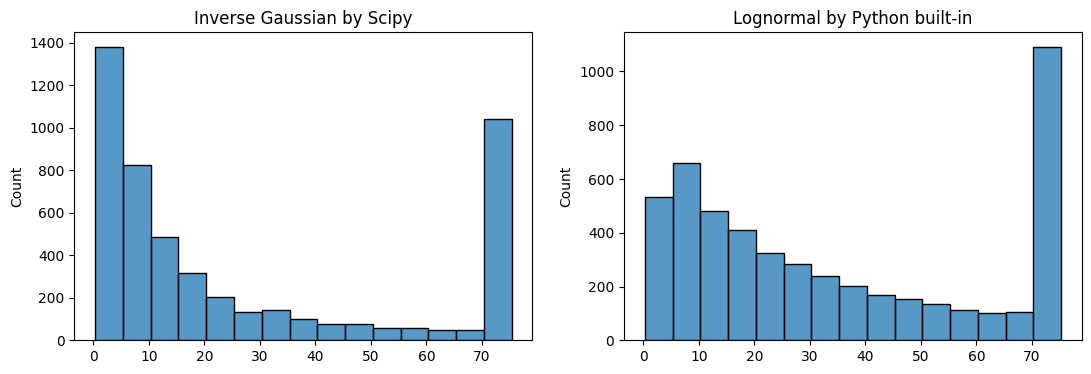

In [88]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(13)
sample_size = 5000
max_price =np.array(df_foodcenter_popular.checkout_price.max())
print('maximum price \t', max_price)


arr_temp =  invgauss.rvs(mu = a1, scale = b1 ** 0.5, size=sample_size)
# arr_temp = np.where(arr_temp > max_price, max_price, arr_temp)
arr_temp = np.fmin(arr_temp, max_price)
plt.subplot(1,2,1)
sns.histplot(x =arr_temp, binwidth = 5).set_title('Inverse Gaussian by Scipy')


# arr_temp =  lognorm.rvs(s = np.log(b2 ** 0.5), loc = np.log(a2 + 7.6351), size=sample_size)
arr_temp = [pyr.lognormvariate(np.log(a2), np.log(b2 ** 0.5)) for i in range(sample_size)]
arr_temp = np.fmin(arr_temp, max_price)
plt.subplot(1,2,2)
sns.histplot(x =arr_temp, binwidth = 5).set_title('Lognormal by Python built-in')

- According to the graph, lognormal distribution generated by python built-in appear to better match the true distribution. 
- One issue with the generators are that the rare values on the right end of the tail are generately somewhat too frequently, which, after truncating, leads to an abnormal high frequency at the right end of the plot.

To offset such issue, a simple algorithm was designed to address the issue, its pseudo code is as:<i>
- - let val be a random sample draw from the distribution,
- - while (val > maximum acceptable value):
- - > let val be a random sample draw from the distribution
- - return val</i>

Below are the implementations.

In [89]:
def get_truncated_invgauss(mu, var, max_val =70) ->float:
    '''
    generate truncated random number from inverse gaussian
    mu: the first parameter in @risk plus the value of risk shift, if any
    var: the seccond parameter in @risk
    '''
    val = invgauss.rvs(mu = mu, scale = var ** 0.5, size = 1)[0]
    while (val > max_val):
        val = invgauss.rvs(mu = mu, scale = var ** 0.5, size = 1)[0]
    return val


def get_truncated_lognorm(mu, var, max_val = 70) ->float:
    '''
    generate truncated random number from log normal
    mu: the first parameter in @risk plus the value of risk shift, if any
    var: the seccond parameter in @risk
    '''
    val = pyr.lognormvariate(np.log(mu), np.log(var ** 0.5))
    while (val > max_val):
        val = pyr.lognormvariate(np.log(mu), np.log(var ** 0.5))
    return val

Text(0.5, 1.0, 'Sample of Lognormal by Refined Algorithm')

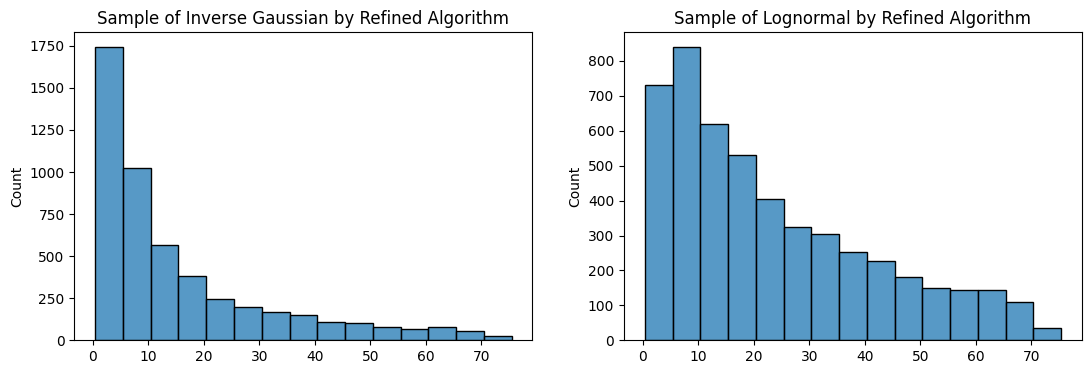

In [90]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(13)
sample_size = 5000

max_price = df_foodcenter_popular.checkout_price.max()
arr_temp =  [get_truncated_invgauss(a1, b1, max_price) for i in range(sample_size)]
plt.subplot(1,2,1)
sns.histplot(x =arr_temp, binwidth = 5).set_title('Sample of Inverse Gaussian by Refined Algorithm')


arr_temp =  [get_truncated_lognorm(a2, b2, max_price) for i in range(sample_size)]
plt.subplot(1,2,2)
sns.histplot(x =arr_temp, binwidth = 5).set_title('Sample of Lognormal by Refined Algorithm')

- With the refinement algorithm, the distribution looks better yet the inverse gaussian still looks like exponential.
- From practical perspective, lognormal is also more frequently seen in the modelling of prices, it is thus chosen as the distribution to model the checkout price.

Text(0.5, 1.0, 'log normal scipy')

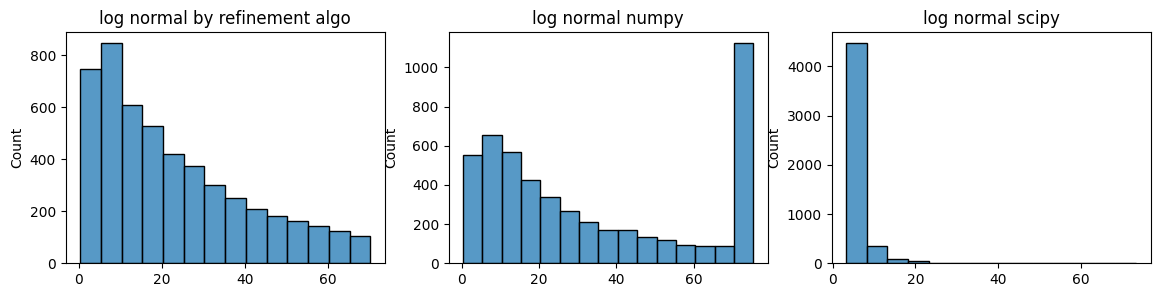

In [91]:
fig, ax =plt.subplots(1,3)
fig.set_figwidth(14)
fig.set_figheight(3)

sample_size = 5000
plt.subplot(1,3,1)
arr_temp = [get_truncated_lognorm(a2, b2) for i in range(sample_size)]
sns.histplot(x =arr_temp, binwidth = 5).set_title('log normal by refinement algo')

plt.subplot(1,3,2)
arr_temp = np.random.lognormal(mean=np.log(a2), sigma=np.log(b2**0.5), size=sample_size)
arr_temp = np.fmin(max_price, arr_temp)
sns.histplot(x =arr_temp, binwidth = 5).set_title('log normal numpy')

plt.subplot(1,3,3)
arr_temp = lognorm.rvs(s = np.log(b2 ** 0.5), loc = np.log(a2),  size=sample_size)
arr_temp = np.fmin(max_price, arr_temp)
sns.histplot(x =arr_temp, binwidth = 5).set_title('log normal scipy')

##### Random Generation of Demand:
- - weekly demand of center 10: $Logistic(23273.1,1791.8)$
- - weekly demand of center 13: $Logistic(29668.1,2009.1)$
- - weekly demand of center 43: $LogLogistic(-7252.4,33859,11.756)$
- - weekly demand of center 52: $Normal(21528.2,3702.3)$
- - weekly demand of center 67: $Logistic(19481.8,1765.0)$
- - weekly demand of center 137: $LogLogistic(-10392,31699,17.297)$
<br></br>
- Random generation of logistic family, using $Logistic(23273.1,1791.8)$

In [92]:
logit_mu = 23273.1
logit_var = 1791.8

dict_logit_param_center10 = {'loc':logit_mu, 'scale':logit_var**0.5}

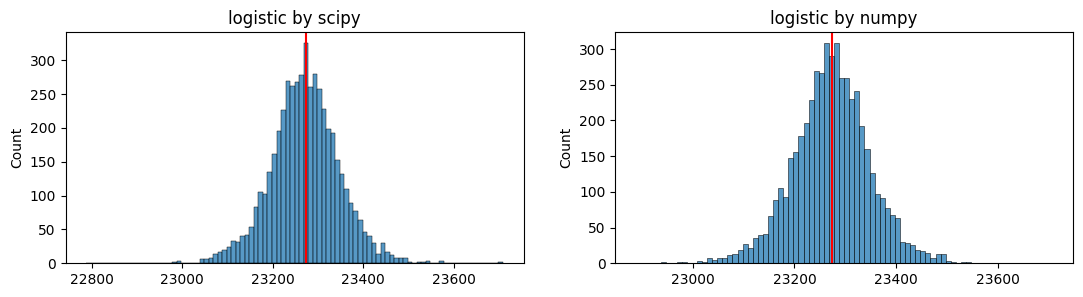

In [93]:
fig, ax =plt.subplots(1,2)
fig.set_figwidth(13)
fig.set_figheight(3)


sample_size = 5000
plt.subplot(1,2,1)
arr_temp = scipy.stats.logistic.rvs(size = sample_size, loc = logit_mu, scale = logit_var ** 0.5)
sns.histplot(x =arr_temp, binwidth = 10).set_title('logistic by scipy')
plt.axvline(x = logit_mu, color = 'r')

plt.subplot(1,2,2)
arr_temp = np.random.logistic(loc=logit_mu, scale=logit_var ** 0.5, size=sample_size)
sns.histplot(x =arr_temp, binwidth = 10).set_title('logistic by numpy')
plt.axvline(x = logit_mu, color = 'red')

It appears either implementation would work. Scipy is preferred.
- Random generation of loglogistic family, using $LogLogistic(-7252.4,33859,11.756)$

In [94]:
loglogit_gamma = -7252.4
loglogit_beta = 33859
loglogit_alpha = 11.756

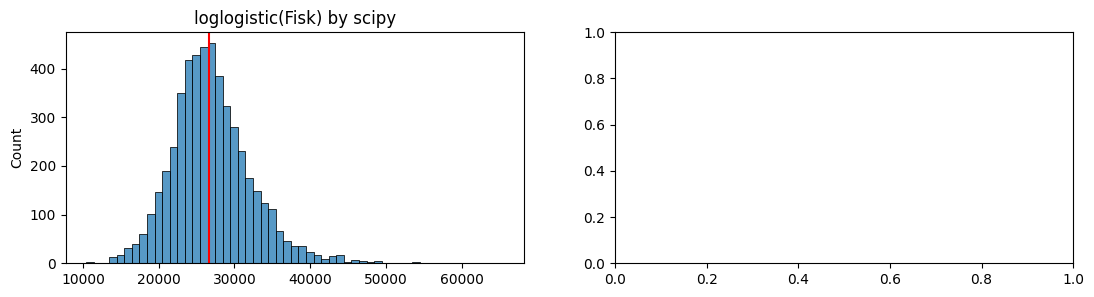

In [95]:
fig, ax =plt.subplots(1,2)
fig.set_figwidth(13)
fig.set_figheight(3)


sample_size = 5000
plt.subplot(1,2,1)
arr_temp = scipy.stats.fisk.rvs(size = sample_size, loc = loglogit_gamma, scale = loglogit_beta, c = loglogit_alpha)
sns.histplot(x =arr_temp, binwidth = 1000).set_title('loglogistic(Fisk) by scipy')
plt.axvline(x = loglogit_beta + loglogit_gamma, color = 'r')
# plt.subplot(1,2,2)
# arr_temp = np.random.logistic(loc=logit_mu, scale=logit_var ** 0.5, size=sample_size)
# sns.histplot(x =arr_temp, binwidth = 10).set_title('logistic by numpy')
# plt.axvline(x = logit_mu, color = 'red')

The loglogistic implementation of Scipy looks good. No loglogistic implementation were found in either numpy or python built-in
- Random generation of normal family, using $Normal(21528.2,3702.3)$

In [96]:
n_mu = 21528.2
n_sigma = 3702.3 ** 0.5

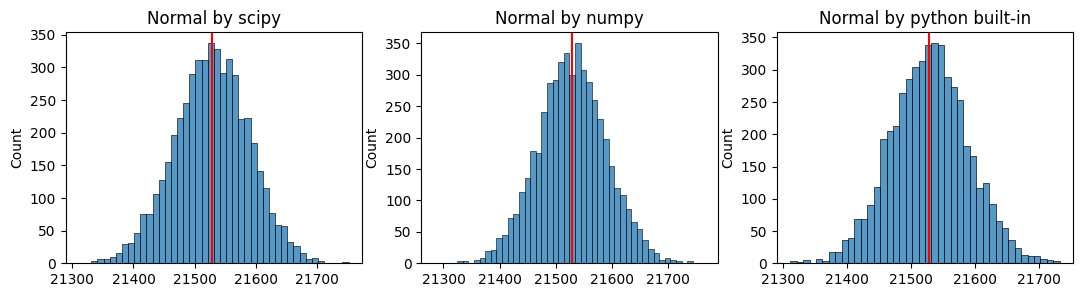

In [97]:
fig, ax =plt.subplots(1,3)
fig.set_figwidth(13)
fig.set_figheight(3)


sample_size = 5000
plt.subplot(1,3,1)
arr_temp = scipy.stats.norm.rvs(size = sample_size, loc = n_mu, scale = n_sigma)
sns.histplot(x =arr_temp, binwidth = 10).set_title('Normal by scipy')
plt.axvline(x = n_mu, color = 'r')


plt.subplot(1,3,2)
arr_temp = np.random.normal(loc=n_mu, scale=n_sigma, size=sample_size)
sns.histplot(x =arr_temp, binwidth = 10).set_title('Normal by numpy')
plt.axvline(x = n_mu, color = 'red')


plt.subplot(1,3,3)
arr_temp = [pyr.normalvariate(mu=n_mu, sigma=n_sigma) for i in range(sample_size)]
sns.histplot(x =arr_temp, binwidth = 10).set_title('Normal by python built-in')
plt.axvline(x = n_mu, color = 'red')

After running the same snippet several times, numpy appears to be most stable.
- As of now, it is planned to use:
- - python built-in generator for lognormal
- - scipy generator for loglogistic
- - scipy generator for logistic
- - numpy generator for normal

#### <b> Algorithmic design</b>

##### Input:
- <b>Number of iteration</b>: An integer value specifying how many times the simulation should be run.
- <b>Number of weeks</b>: An integer specifying how many weeks their would be in each iteration. It should be same to all the users.
- <b>Selection of locations</b>: One or few strings where each string corresponds to a center. It is determined by the users and will be traversed in every iteration.
- <b>sS policies</b>: One or few integer tuples where each tuple corresponds to a sS policy for a center.

##### Output:

- <b>Total profit</b>: average and standard deviation.

- <b>Total shortage</b>: average and standard deviation.

In [98]:
df_foodcenter_popular.groupby(['week', 'center_id']).agg(
    weekly_revenue = pd.NamedAgg(column = 'revenue', aggfunc = 'sum')
)['weekly_revenue'].reset_index().weekly_revenue.mean()

614932.4431297618

In [99]:
df_foodcenter_popular.num_orders = df_foodcenter_popular.num_orders.map(lambda v: round(v/10))
df_foodcenter_popular.revenue = df_foodcenter_popular.num_orders * df_foodcenter_popular.checkout_price

C:\Users\Chaconne\AppData\Local\Temp\ipykernel_7872\3243036388.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_foodcenter_popular.num_orders = df_foodcenter_popular.num_orders.map(lambda v: round(v/10))
C:\Users\Chaconne\AppData\Local\Temp\ipykernel_7872\3243036388.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_foodcenter_popular.revenue = df_foodcenter_popular.num_orders * df_foodcenter_popular.checkout_price


In [101]:
df_foodcenter_popular.revenue = df_foodcenter_popular.revenue.round()

C:\Users\Chaconne\AppData\Local\Temp\ipykernel_7872\3457075046.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_foodcenter_popular.revenue = df_foodcenter_popular.revenue.round()


In [147]:
df_foodcenter_popular.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,diff_price,revenue
194,1171094,1,13,1885,13.586,12.228,0,1,213,Beverages,Thai,1.358,2894.0
195,1068455,1,13,1993,13.486,12.228,0,1,242,Beverages,Thai,1.258,3264.0
196,1105491,1,13,2539,13.386,13.386,0,0,47,Beverages,Thai,0.000,629.0
197,1486384,1,13,2139,33.762,43.753,0,0,12,Beverages,Indian,-9.991,405.0
198,1345938,1,13,2631,25.223,43.747,0,0,16,Beverages,Indian,-18.524,404.0


In [146]:
df_foodcenter_popular.groupby(['week', 'center_id']).agg(
    weekly_revenue = pd.NamedAgg(column = 'revenue', aggfunc = 'sum')
)['weekly_revenue'].reset_index()

,week,center_id,weekly_revenue
0,1,10,70660.0
1,1,13,77774.0
2,1,43,66187.0
3,1,52,49632.0
4,1,67,45708.0
...,...,...,...
835,140,13,86848.0
836,140,43,74659.0
837,140,52,67078.0
838,140,67,62595.0


In [110]:
df_foodcenter_popular.checkout_price.mode()

0    29.103
1    29.203
Name: checkout_price, dtype: float64

In [136]:
df_foodcenter_popular.checkout_price.sample(n = 5000).mode()

# df_foodcenter_popular.checkout_price.to_csv('checkout_price_transformed.csv')

0    29.203
Name: checkout_price, dtype: float64

In [139]:
df_foodcenter_popular.checkout_price.var() ** 0.5

15.256136104434002

In [145]:
df_foodcenter_popular.checkout_price.mean()

33.37792413947029

<AxesSubplot:xlabel='checkout_price', ylabel='Count'>

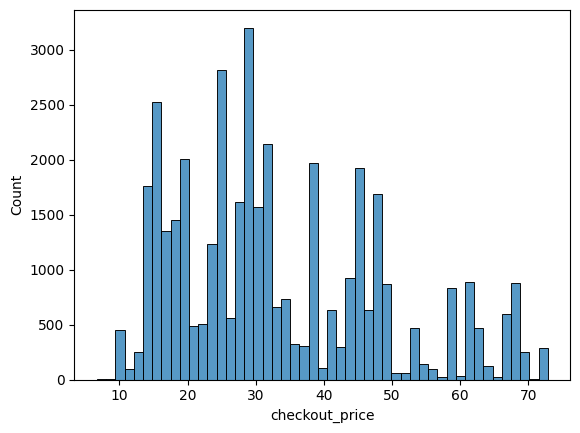

In [140]:
sns.histplot(data = df_foodcenter_popular.checkout_price)

In [144]:
df_temp = df_foodcenter_popular.groupby(['week', 'center_id']).agg(
    weekly_orders = pd.NamedAgg(column = 'num_orders', aggfunc = 'sum')
).reset_index()
df_temp.weekly_orders.describe()

count     840.000000
mean     2379.620238
std       522.200572
min       853.000000
25%      2014.500000
50%      2313.500000
75%      2709.000000
max      4774.000000
Name: weekly_orders, dtype: float64